In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import DirectoryIterator
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
import keras_tuner as kt
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from typing import Tuple # Type hint

C:\Users\Akoba\AppData\Local\Temp\ipykernel_21472\3801991149.py:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
path = 'C:/Users/Akoba/Desktop/START up/Covid19_research_project/data/raw/xray_images'

In [3]:
train_dir = path + '/LungData/train'
val_dir = path + '/LungData/val'
test_dir = path + '/LungData/test'

In [4]:
image_generator = ImageDataGenerator(
                                      rotation_range=20,
                                      width_shift_range=0.1,
                                      shear_range=0.1,
                                      zoom_range=0.1,
                                      samplewise_center=True,
                                      samplewise_std_normalization=True
                                     )

In [5]:
# Create the training data generator
train_generator = image_generator.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),  # Resize images to 224x224 pixels
    batch_size=8,  # Process 8 images per batch
    shuffle=True,  # Shuffle the order of images
    class_mode='categorical'  # Multiple classes for classification
)

# Create the validation data generator
validation_generator = image_generator.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224),  # Resize images to 224x224 pixels
    batch_size=1,  # Process 1 image per batch
    shuffle=False,  # Do not shuffle the order of images
    class_mode='categorical'  # Multiple classes for classification
)

# Create the test data generator
test_generator = image_generator.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),  # Resize images to 224x224 pixels
    batch_size=1,  # Process 1 image per batch
    shuffle=False,  # Do not shuffle the order of images
    class_mode='categorical'  # Multiple classes for classification
)


Found 1381 images belonging to 2 classes.
Found 345 images belonging to 2 classes.
Found 433 images belonging to 2 classes.


In [6]:
def plot_preprocessed_images(train: DirectoryIterator, num_images_per_class: int) -> None:
    """
    Plots preprocessed images from each class in the training set.

    Args:
        train (DirectoryIterator): The training data iterator.
        num_images_per_class (int): Number of preprocessed images to plot from each class.

    Returns:
        None
    """
    # Initialize counters for each class
    normal_count = 0
    covid_count = 0

    # Plot preprocessed images from each class
    fig, axes = plt.subplots(2, num_images_per_class, figsize=(12, 6))

    for images, labels in train:
        for i in range(len(images)):
            # Get the corresponding class label
            class_label = labels[i]

            # Plot the image based on the class label
            if class_label[0] == 1:
                if covid_count < num_images_per_class:
                    axes[0, covid_count].imshow(images[i])
                    axes[0, covid_count].set_title('COVID-19')
                    axes[0, covid_count].axis('off')
                    covid_count += 1
            elif class_label[1] == 1:
                if normal_count < num_images_per_class:
                    axes[1, normal_count].imshow(images[i])
                    axes[1, normal_count].set_title('NORMAL')
                    axes[1, normal_count].axis('off')
                    normal_count += 1

        if normal_count >= num_images_per_class and covid_count >= num_images_per_class:
            break

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


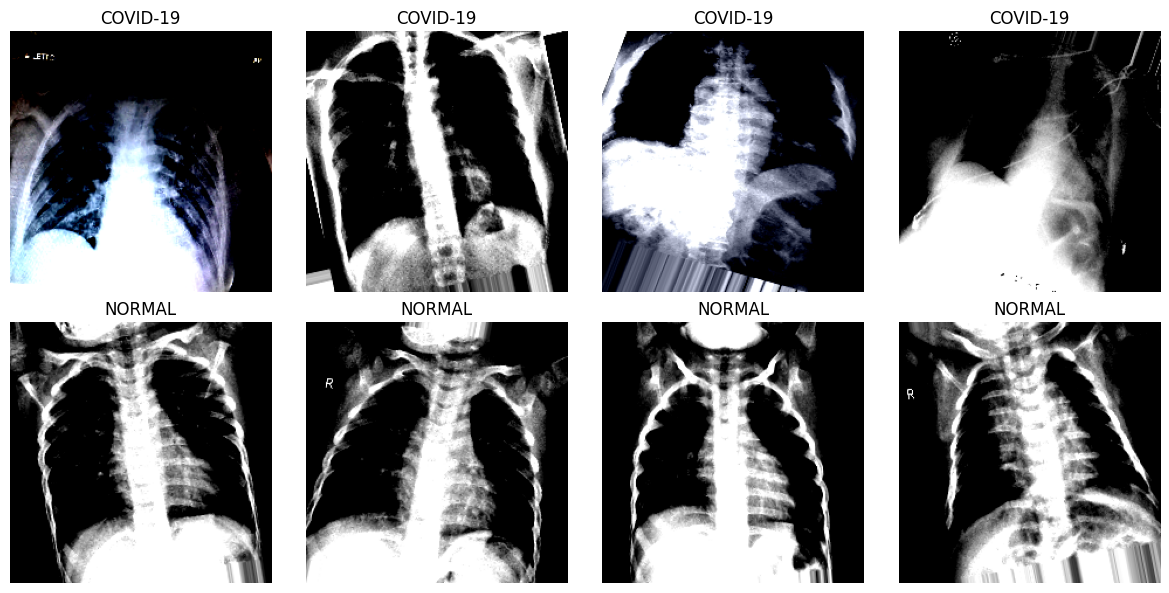

In [7]:
plot_preprocessed_images(train=train_generator, num_images_per_class=4)

In [8]:
def display_image_and_histogram(image, label):
    """
    Display a processed chest X-ray image and its pixel intensity histogram.

    Args:
        image (np.array): The processed chest X-ray image.
        label (str): The label for the image.

    Returns:
        None
    """
    sns.set_style('white')

    fig, axs = plt.subplots(2, 1, figsize=(8, 10))

    # Display the image in the first subplot
    axs[0].imshow(image, cmap='gray')
    axs[0].set_title(f"Processed Chest X-Ray Image: {label}")
    axs[0].axis('off')

    # Display the histogram in the second subplot
    sns.histplot(image.ravel(),
                 label=f"Mean: {np.mean(image):.4f}, Std Dev: {np.std(image):.4f}",
                 kde=False, ax=axs[1])
    axs[1].legend(loc='upper center')
    axs[1].set_title('Pixel Intensity Distribution')
    axs[1].set_xlabel('Pixel Intensity')
    axs[1].set_ylabel('Number of Pixels')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Print image details
    print(f"Image dimensions: {image.shape[0]} x {image.shape[1]} pixels, single color channel.")
    print(f"Maximum pixel value: {image.max():.4f}")
    print(f"Minimum pixel value: {image.min():.4f}")
    print(f"Mean pixel value: {image.mean():.4f}")
    print(f"Standard deviation of pixel values: {image.std():.4f}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


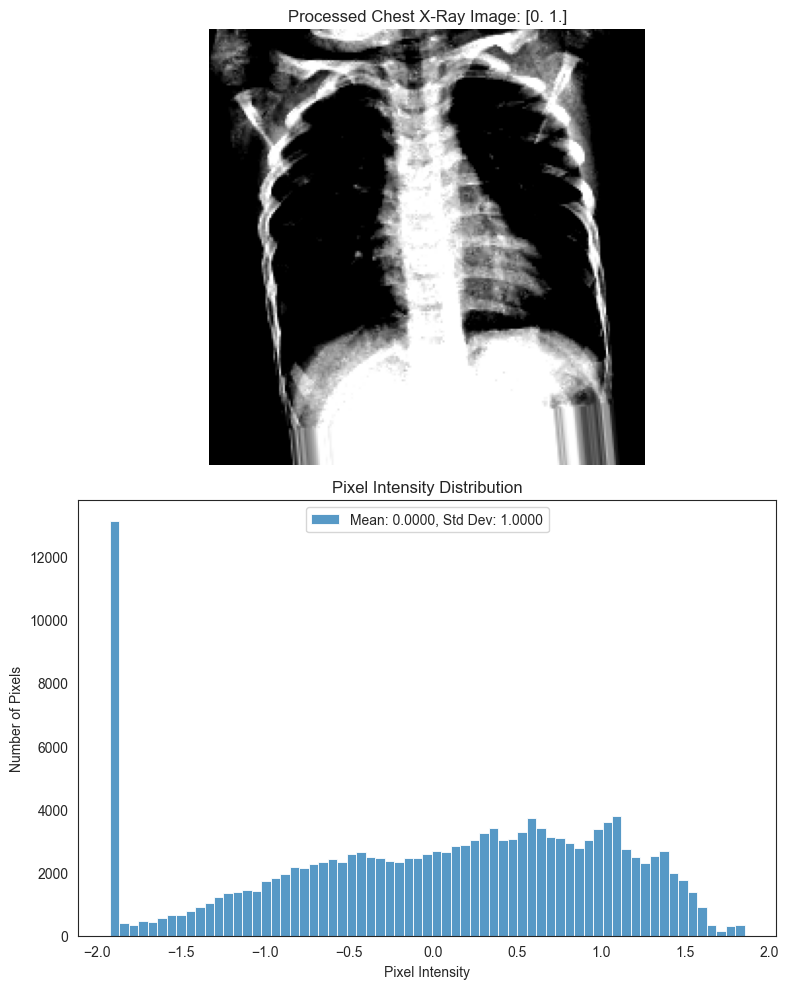

Image dimensions: 224 x 224 pixels, single color channel.
Maximum pixel value: 1.8521
Minimum pixel value: -1.9253
Mean pixel value: 0.0000
Standard deviation of pixel values: 1.0000


In [9]:
generated_image, label = train_generator.__getitem__(0)
image = generated_image[0]
label = label[0]
display_image_and_histogram(image, label)

In [10]:
path = 'C:/Users/Akoba/Desktop/START up/Covid19_research_project/data/raw/xray_images'
train_dir = os.path.join(path + '/LungData/train')
val_dir = os.path.join(path + '/LungData/val')
test_dir = os.path.join(path + '/LungData/test')

print("Train set:\n____________________")

num_covid19_train = len(os.listdir(os.path.join(train_dir, 'COVID19')))
num_normal_train = len(os.listdir(os.path.join(train_dir, 'NORMAL')))

print(f"COVID19 = {num_covid19_train}")
print(f"NORMAL = {num_normal_train}")

Train set:
____________________
COVID19 = 368
NORMAL = 1013


In [11]:
# Calculate the total number of training samples
total_samples = num_covid19_train + num_normal_train

# Compute class weights to handle class imbalance
class_weight_covid19 = total_samples / (3 * num_covid19_train)
class_weight_normal = total_samples / (3 * num_normal_train)

# Create a dictionary to store the class weights
class_weights = {0: class_weight_covid19, 1: class_weight_normal}

# Print out the calculated class weights
print(f"Weight for COVID-19 class (0): {class_weight_covid19:.2f}")
print(f"Weight for NORMAL class (1): {class_weight_normal:.2f}")

Weight for COVID-19 class (0): 1.25
Weight for NORMAL class (1): 0.45


In [12]:
class_weights

{0: 1.2509057971014492, 1: 0.4544257979598552}

In [13]:
def build_model(hp):
    """
    Builds a convolutional neural network model with hyperparameter tuning.

    Parameters:
    - hp (kerastuner.HyperParameters): HyperParameters object for tuning the model.

    Returns:
    - keras.Sequential: The compiled model.
    """
    model = keras.Sequential()

    # Tune the number of convolutional layers
    for i in range(hp.Int('num_conv_layers', min_value=1, max_value=4)):
        model.add(layers.Conv2D(hp.Int(f'filters_{i}', min_value=32, max_value=256),
                                kernel_size=hp.Choice(f'kernel_size_{i}', values=[3, 5]),
                                activation='relu'))
        model.add(layers.MaxPooling2D(pool_size=hp.Choice(f'pool_size_{i}', values=[2, 3])))

    model.add(layers.Flatten())

    # Tune the number of dense layers
    for i in range(hp.Int('num_dense_layers', min_value=1, max_value=3)):
        model.add(layers.Dense(units=hp.Int(f'num_units_{i}', min_value=64, max_value=512),
                                activation='relu'))
        # Tune the dropout rate
        model.add(layers.Dropout(rate=hp.Float(f'dropout_rate_{i}', min_value=0.0, max_value=0.5)))

    model.add(layers.Dense(2, activation='softmax'))  # 2 classes: COVID19 and NORMAL

    # Tune the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Use standard optimizers
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])

    optimizer = keras.optimizers.get({
        'class_name': hp_optimizer,
        'config': {'learning_rate': hp_learning_rate}
    })

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [14]:
from keras.callbacks import EarlyStopping

# Set up the random search tuner
tuner = RandomSearch(
    hypermodel=build_model,  # Function that returns a compiled model
    objective='val_accuracy',  # Objective metric to optimize
    max_trials=2,  # Total number of trials to run
    executions_per_trial=1,  # Number of model fits per trial
    directory=os.path.join(path, 'tuner_directory'),  # Path to save logs and models
    project_name='covid-19 classification'  # Tuning session name
)

# Initialize early stopping mechanism
stop_early = EarlyStopping(monitor='val_loss', patience=10)  # Halt training when val_loss stops improving

# Execute the search for optimal hyperparameters
tuner.search(
    x=train_generator,  # Training data generator
    epochs=20,  # Number of epochs to train each model configuration
    validation_data=validation_generator,  # Validation data generator
    callbacks=[stop_early]  # List of callbacks to apply during training
)

Reloading Tuner from C:/Users/Akoba/Desktop/START up/Covid19_research_project/data/raw/xray_images\tuner_directory\covid-19 classification\tuner0.json


In [15]:
# Acquire the optimal hyperparameters
optimal_hp = tuner.get_best_hyperparameters()[0]
  # The get_best_hyperparameters() function retrieves a list of top hyperparameter sets.
  # Selecting the first item [0] gives us the set with the best performance.

# Display the optimal hyperparameters 
print("Optimal Hyperparameters:")
print(f"- Convolutional Layers Count: {optimal_hp.get('num_conv_layers')}")
for layer_index in range(optimal_hp.get('num_conv_layers')):
    print(f"  - Conv Layer {layer_index+1} Filters: {optimal_hp.get(f'filters_{layer_index}')}")
    print(f"  - Conv Layer {layer_index+1} Kernel Size: {optimal_hp.get(f'kernel_size_{layer_index}')}")
    print(f"  - Conv Layer {layer_index+1} Pooling Size: {optimal_hp.get(f'pool_size_{layer_index}')}")
print(f"- Dense Layers Count: {optimal_hp.get('num_dense_layers')}")
for layer_index in range(optimal_hp.get('num_dense_layers')):
    print(f"  - Dense Layer {layer_index+1} Units: {optimal_hp.get(f'num_units_{layer_index}')}")
    print(f"  - Dense Layer {layer_index+1} Dropout: {optimal_hp.get(f'dropout_rate_{layer_index}')}")
print(f"- Learning Rate: {optimal_hp.get('learning_rate')}")
# Ensure to include 'Coati' if it's the selected optimizer
optimizer = optimal_hp.get('optimizer')
print(f"- Optimizer: {'Coati' if optimizer == 'Coati' else optimizer}")

Optimal Hyperparameters:
- Convolutional Layers Count: 4
  - Conv Layer 1 Filters: 43
  - Conv Layer 1 Kernel Size: 5
  - Conv Layer 1 Pooling Size: 2
  - Conv Layer 2 Filters: 94
  - Conv Layer 2 Kernel Size: 5
  - Conv Layer 2 Pooling Size: 2
  - Conv Layer 3 Filters: 32
  - Conv Layer 3 Kernel Size: 3
  - Conv Layer 3 Pooling Size: 2
  - Conv Layer 4 Filters: 32
  - Conv Layer 4 Kernel Size: 3
  - Conv Layer 4 Pooling Size: 2
- Dense Layers Count: 1
  - Dense Layer 1 Units: 310
  - Dense Layer 1 Dropout: 0.13147344336623235
- Learning Rate: 0.001
- Optimizer: sgd


In [16]:
def best_model():
    model = keras.Sequential()
    input_shape = (224, 224, 3)
    
    # Convolutional layers
    model.add(layers.Conv2D(156, kernel_size=3, activation='relu', input_shape=(input_shape)))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(149, kernel_size=3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(192, kernel_size=3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=3))
    model.add(layers.Conv2D(254, kernel_size=5, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))

    model.add(layers.Flatten())

    # Dense layers
    model.add(layers.Dense(188, activation='relu'))
    model.add(layers.Dropout(0.4296478261801449))
    model.add(layers.Dense(310, activation='relu'))
    model.add(layers.Dropout(0.20158293434446))
    model.add(layers.Dense(2, activation='softmax'))  # 3 classes: COVID19 andNORMAL

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                  loss='categorical_crossentropy', # categorical_crossentropy loss function porque es Multi-class
                  metrics=['accuracy'])

    return model

# Create the model
best_model = best_model()

c:\Users\Akoba\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# Assemble the model using the optimal hyperparameters
model = tuner.hypermodel.build(optimal_hp)

# Initialize early stopping mechanism
stop_early = EarlyStopping(monitor='val_loss', patience=5)  # Halt training when val_loss stops improving

# Commence training of the top-performing model
training_process = model.fit(train_generator, 
                                         epochs=20,
                                         batch_size=32,
                                         validation_data=validation_generator, 
                                         class_weight=class_weights
                                        )

# Persisting the model post-training
model.save(os.path.join(path, 'models', '1model_cnn_coati.h5'))

Epoch 1/20


c:\Users\Akoba\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


173/173 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.8252 - loss: 0.3818 - val_accuracy: 0.8899 - val_loss: 0.3083
Epoch 2/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9110 - loss: 0.1844 - val_accuracy: 0.9478 - val_loss: 0.1866
Epoch 3/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.9176 - loss: 0.1619 - val_accuracy: 0.9391 - val_loss: 0.1668
Epoch 4/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.9408 - loss: 0.1187 - val_accuracy: 0.9391 - val_loss: 0.1735
Epoch 5/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.9431 - loss: 0.1114 - val_accuracy: 0.9565 - val_loss: 0.1570
Epoch 6/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.9505 - loss: 0.1110 - val_accuracy: 0.9478 - val_loss: 0.1532
Epoch 7/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 175s 995ms/step - accuracy: 0.9459 - loss: 0.1019 - val_accuracy: 0.9449 - val_loss: 0.1609
Epoch 8/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 172s 981ms/step - accuracy: 0.9499 - loss: 0.1007 - val_accuracy:

In [18]:
# save the weights
model.save_weights('C:/Users/Akoba/Desktop/START up/Covid19_research_project/models/cnn/w-o-imagemodel_weights.weights.h5')

In [19]:
# To save the model once it has been trained 
model.save('C:/Users/Akoba/Desktop/START up/Covid19_research_project/models/cnn/w-o-imagemodel_covid_classif.h5')

In [20]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 220, 220, 43)   │         3,268 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 110, 110, 43)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 106, 106, 94)   │       101,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 53, 53, 94)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 51, 51, 32)     │        27,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 23, 23, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 310)            │     1,200,630 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 310)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           622 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,342,018 (5.12 MB)

 Trainable params: 1,342,016 (5.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [21]:
# Determine the most suitable number of epochs for model training using the acquired hyperparameters.
validation_accuracy_each_epoch = training_process.history['val_accuracy']
optimal_epoch = validation_accuracy_each_epoch.index(max(validation_accuracy_each_epoch)) + 1
print('Optimal epoch for training: %d' % (optimal_epoch,))

Optimal epoch for training: 9


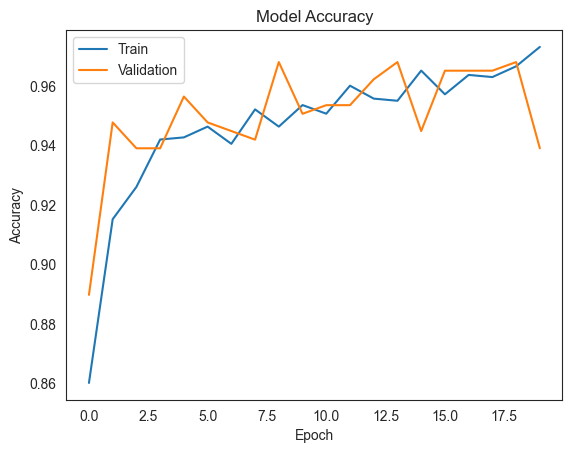

In [22]:
plt.plot(training_process.history['accuracy'])
plt.plot(training_process.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

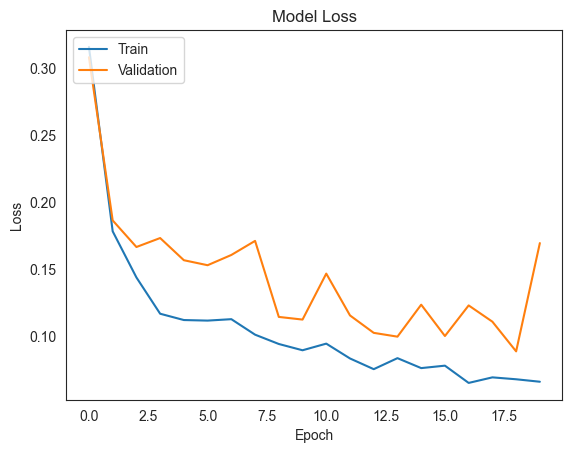

In [23]:
plt.plot(training_process.history['loss'])
plt.plot(training_process.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [24]:
# Evaluate the best model on the test set
evaluation = model.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

433/433 ━━━━━━━━━━━━━━━━━━━━ 37s 85ms/step - accuracy: 0.9629 - loss: 0.0882
Test Accuracy: 95.61%
173/173 ━━━━━━━━━━━━━━━━━━━━ 82s 474ms/step - accuracy: 0.9552 - loss: 0.1485
Train Accuracy: 95.80%


In [25]:
predicted = model.predict(test_generator) # y_score

433/433 ━━━━━━━━━━━━━━━━━━━━ 36s 83ms/step


In [26]:
predicted # predicted.shape: (****, 2)

array([[9.73718107e-01, 2.62818988e-02],
       [9.99858499e-01, 1.41498080e-04],
       [9.99934793e-01, 6.51802693e-05],
       [5.08708596e-01, 4.91291374e-01],
       [9.97327328e-01, 2.67267181e-03],
       [9.99889612e-01, 1.10380213e-04],
       [4.95318025e-01, 5.04682004e-01],
       [9.99861598e-01, 1.38422256e-04],
       [7.94367015e-01, 2.05632910e-01],
       [9.99082208e-01, 9.17790341e-04],
       [9.97936249e-01, 2.06373609e-03],
       [9.99601305e-01, 3.98755918e-04],
       [9.99781787e-01, 2.18236237e-04],
       [9.99959111e-01, 4.09154527e-05],
       [9.99977827e-01, 2.22279905e-05],
       [9.99780834e-01, 2.19236259e-04],
       [9.95605767e-01, 4.39425278e-03],
       [9.99689221e-01, 3.10756848e-04],
       [9.98017669e-01, 1.98233686e-03],
       [9.99982357e-01, 1.76406375e-05],
       [9.99979854e-01, 2.01158982e-05],
       [9.99999046e-01, 9.78816502e-07],
       [9.98405755e-01, 1.59428781e-03],
       [9.99951482e-01, 4.85439305e-05],
       [9.992115

In [27]:
# 'np.argmax(p)' retrieves the index of the highest value in 'p', which aligns with the class that the model's softmax output deems most probable.
predicted_classes = [np.argmax(probability) for probability in predicted] # holds the predicted classes for each sample in the test set

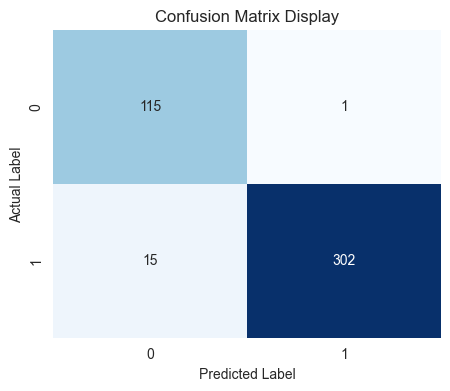

In [28]:
# Retrieve actual class labels
actual_classes = test_generator.classes # Example output: array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

# Generate the confusion matrix
conf_matrix = confusion_matrix(actual_classes, predicted_classes)

# Visualize the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix Display')
plt.show()

In [29]:
target_names = ['Class 0: COVID19', 'Class 1: NORMAL']
print(classification_report(actual_classes, predicted_classes, target_names=target_names))

                  precision    recall  f1-score   support

Class 0: COVID19       0.88      0.99      0.93       116
 Class 1: NORMAL       1.00      0.95      0.97       317

        accuracy                           0.96       433
       macro avg       0.94      0.97      0.95       433
    weighted avg       0.97      0.96      0.96       433



In [30]:
# Load the model
new_model = tf.keras.models.load_model('C:/Users/Akoba/Desktop/START up/Covid19_research_project/models/cnn/w-o-imagemodel_covid_classif.h5')
# Check its architecture
new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 220, 220, 43)   │         3,268 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 110, 110, 43)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 106, 106, 94)   │       101,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 53, 53, 94)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 51, 51, 32)     │        27,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 23, 23, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 310)            │     1,200,630 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 310)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           622 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,342,018 (5.12 MB)

 Trainable params: 1,342,016 (5.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

433/433 ━━━━━━━━━━━━━━━━━━━━ 39s 90ms/step


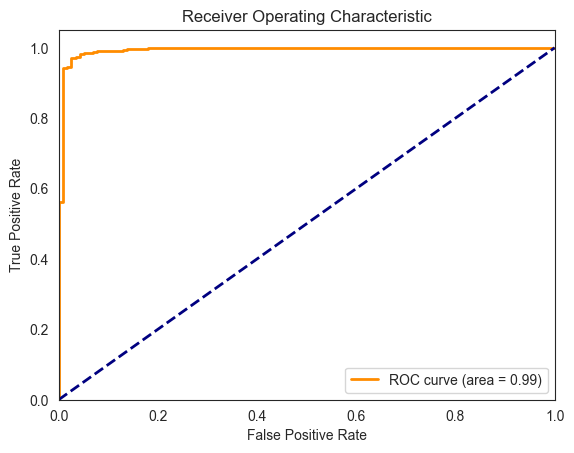

In [31]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

predicted_probabilities = model.predict(test_generator)

# Assuming binary classification and 'predicted_probabilities' is a 2D array with shape (n_samples, n_classes)
# where each column is the probability for each class.
# We take the probabilities for the positive class (usually class 1)
positive_class_probabilities = predicted_probabilities[:, 1]

# Compute ROC curve and ROC area for the positive class
fpr, tpr, _ = roc_curve(actual_classes, positive_class_probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


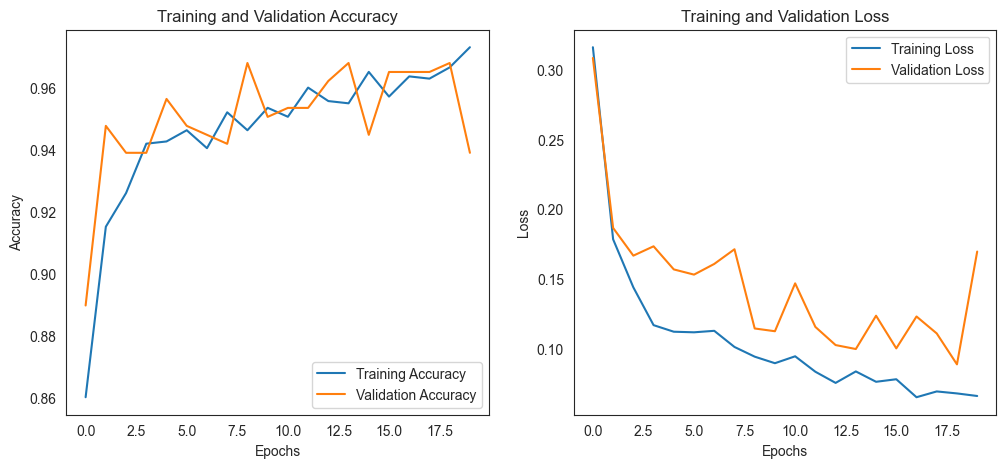

In [32]:
import matplotlib.pyplot as plt

# Assuming the training history is stored in a variable named 'history'
# Example: history = model.fit(...)

# Plotting accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(training_process.history['accuracy'], label='Training Accuracy')
plt.plot(training_process.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(training_process.history['loss'], label='Training Loss')
plt.plot(training_process.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

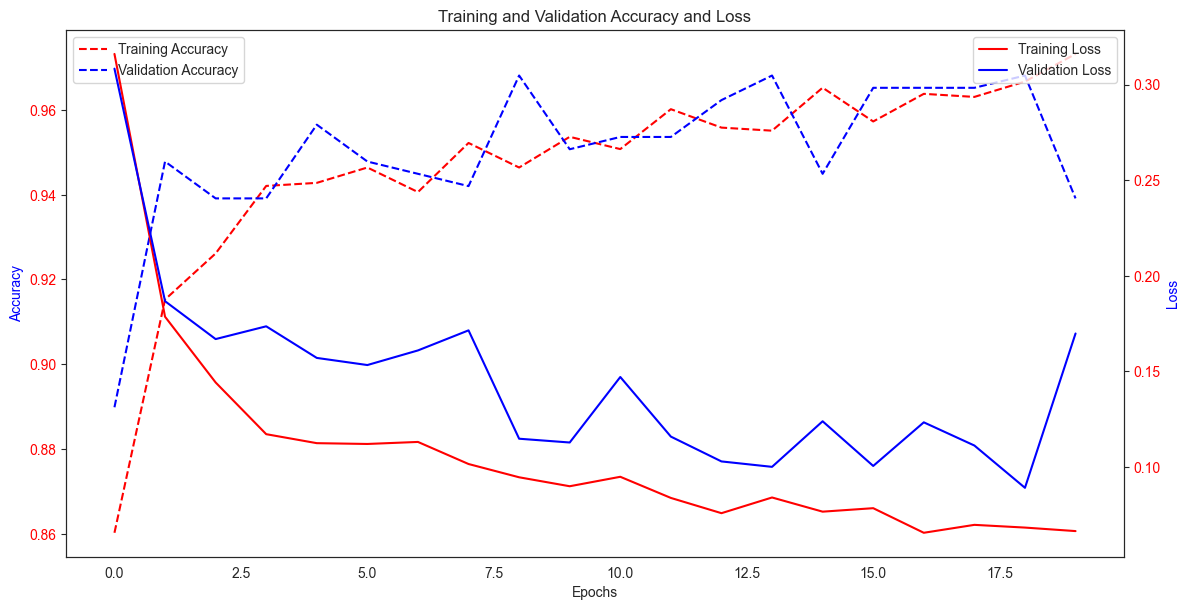

In [33]:
# Create a new figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot accuracy on the first y-axis
ax1.plot(training_process.history['accuracy'], label='Training Accuracy', color='red', linestyle='dashed')
ax1.plot(training_process.history['val_accuracy'], label='Validation Accuracy', color='blue', linestyle='dashed')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='blue')
ax1.tick_params(axis='y', labelcolor='red')

# Create a second y-axis to plot loss
ax2 = ax1.twinx()
ax2.plot(training_process.history['loss'], label='Training Loss', color='red')
ax2.plot(training_process.history['val_loss'], label='Validation Loss', color='blue')
ax2.set_ylabel('Loss', color='blue')
ax2.tick_params(axis='y', labelcolor='red')

# Add legends
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Training and Validation Accuracy and Loss')
plt.show()
